<a href="https://colab.research.google.com/github/KGochae/SOOP-/blob/main/SOOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install isodate
import pandas as pd
import numpy as np
import re
import os
import glob
from datetime import timedelta
from tqdm import tqdm

import requests
import datetime
import tempfile
import re
import pytz
import isodate
import seaborn as sns


# SOOP



### 다시보기 끊겨진거 전처리


In [ ]:
# test
# 파일 경로 설정
# file_path = '241008_13865277_베스트일레본(1+2).txt'
# .txt 파일을 데이터프레임으로 불러오기
# df = pd.read_csv(file_path, sep='\t')  # 탭 구분자 사용 시
# df.head()

In [ ]:
# 파일 경로 설정
path1='/content/drive/MyDrive/SOOP/2월/240208_115693855_이니셜D.txt'
path2='/content/drive/MyDrive/SOOP/2월/240208_115734565_이니셜D.txt'


def read_file(file_path):
  # 파일명에서 date, videoId, title 추출
  file_name = os.path.basename(file_path).replace('.txt', '')  # 확장자 제거
  date_str, videoId, title = file_name.split('_')  # 구분자 '_'로 분리하여 필요한 값 추출

  # '241002' 형식의 date를 '2024-10-02' 형식으로 변환
  date = pd.to_datetime(f'20{date_str}', format='%Y%m%d').strftime('%Y-%m-%d')

  # 빈 리스트를 만들어 각 행을 저장
  data = []

  # 파일 열기 및 내용 추출
  with open(file_path, 'r', encoding='utf-8') as file:
      for line in file:
          # 정규식을 이용해 시간, 닉네임, 아이디, 내용을 추출
          match = re.search(r'\[(.*?)\]\s*(.*?)\((.*?)\):\s*(.*)', line)
          if match:
              time = match.group(1)      # 시간
              nickname = match.group(2)  # 닉네임
              user_id = match.group(3)   # 아이디
              message = match.group(4)   # 내용
              data.append([date, videoId, title, time, nickname, user_id, message])
  # 데이터프레임으로 변환
  df = pd.DataFrame(data, columns=['date', 'videoId', 'title', 'timestamp', 'nickname', 'id', 'content'])
  return df

df1 = read_file(path1)
df2 = read_file(path2)


In [ ]:
df1.head(10)

,date,videoId,title,timestamp,nickname,id,content
0,2024-02-08,115693855,이니셜D,00:00:06,^ㅣ발낙지,njuneimbh,와카
1,2024-02-08,115693855,이니셜D,00:00:08,5143862k,5143862k,왁하
2,2024-02-08,115693855,이니셜D,00:00:09,김뮬,wl1478911,옥하
3,2024-02-08,115693855,이니셜D,00:00:10,밥도둑쓰,wjddml7131,왁하
4,2024-02-08,115693855,이니셜D,00:00:11,종ㅇㅣ학,jkon0902,왁하
5,2024-02-08,115693855,이니셜D,00:00:11,어서오소!,june1310,왁하
6,2024-02-08,115693855,이니셜D,00:00:11,생동이,kimth1130,왁하
7,2024-02-08,115693855,이니셜D,00:00:12,씨비티,jaerm14,왁하
8,2024-02-08,115693855,이니셜D,00:00:12,김뮬,wl1478911,왁하
9,2024-02-08,115693855,이니셜D,00:00:12,엔딜로프,steve96711,왁하


In [ ]:
def timestamp(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  # 시간 덧셈 (예: 06:08:34를 timedelta로 더하기)
  additional_time = timedelta(hours=0,minutes=58, seconds=7)
  df['timestamp'] = df['timestamp'] + additional_time
  df['timestamp'] = df['timestamp'].dt.time
  return df

df2 = timestamp(df2)


<ipython-input-40-88601faeb2d5>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
df = pd.concat([df1, df2])
# .txt 파일로 저장
df.to_csv('/content/drive/MyDrive/SOOP/2월/240208_115693855_이니셜D(1,2).txt', sep='\t', index=False)


In [ ]:
df.head(10)

,date,videoId,title,timestamp,nickname,id,content
0,2024-02-08,115693855,이니셜D,00:00:06,^ㅣ발낙지,njuneimbh,와카
1,2024-02-08,115693855,이니셜D,00:00:08,5143862k,5143862k,왁하
2,2024-02-08,115693855,이니셜D,00:00:09,김뮬,wl1478911,옥하
3,2024-02-08,115693855,이니셜D,00:00:10,밥도둑쓰,wjddml7131,왁하
4,2024-02-08,115693855,이니셜D,00:00:11,종ㅇㅣ학,jkon0902,왁하
5,2024-02-08,115693855,이니셜D,00:00:11,어서오소!,june1310,왁하
6,2024-02-08,115693855,이니셜D,00:00:11,생동이,kimth1130,왁하
7,2024-02-08,115693855,이니셜D,00:00:12,씨비티,jaerm14,왁하
8,2024-02-08,115693855,이니셜D,00:00:12,김뮬,wl1478911,왁하
9,2024-02-08,115693855,이니셜D,00:00:12,엔딜로프,steve96711,왁하


### 월별 데이터 불러오기

In [ ]:
import pandas as pd
import re
import os
import glob
from datetime import timedelta


In [ ]:

# 폴더 경로 설정
folder_path = '/content/drive/MyDrive/SOOP/8월'

# 폴더 내 모든 .txt 파일 경로를 리스트로 가져오기
file_paths = glob.glob(os.path.join(folder_path, '*.txt'))

# 빈 리스트를 만들어 모든 파일의 데이터를 저장
all_data = []

for file_path in file_paths:
    # 파일명에서 date, videoId, title 추출
    file_name = os.path.basename(file_path).replace('.txt', '')  # 확장자 제거
    date_str, videoId, title = file_name.split('_')  # 구분자 '_'로 분리하여 필요한 값 추출

    # '241002' 형식의 date를 '2024-10-02' 형식으로 변환
    date = pd.to_datetime(f'20{date_str}', format='%Y%m%d').strftime('%Y-%m-%d')

    # 파일 열기 및 내용 추출
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # 정규식 (시간, 닉네임, 아이디, 내용)
            match = re.search(r'\[(.*?)\]\s*(.*?)\((.*?)\):\s*(.*)', line)
            if match:
                time = match.group(1)      # 시간
                nickname = match.group(2)  # 닉네임
                user_id = match.group(3)   # 아이디
                message = match.group(4)   # 내용
                all_data.append([date, videoId, title, time, nickname, user_id, message])

# 리스트를 데이터프레임으로 변환
df = pd.DataFrame(all_data, columns=['date', 'videoId', 'title', 'timestamp', 'nickname', 'id', 'content'])


In [ ]:
print(df['date'].min())
print(df['date'].max())

2024-10-02
2024-10-31


In [ ]:
# 소프트콘 데이터
softcon = pd.read_csv('/content/drive/MyDrive/SOOP/softcon_chat.csv')


## 월별 이모티콘과 일부 키워드 집계


In [ ]:
# timestamp 컬럼에서 날짜를 지정한 날짜로 변경 (시간 부분은 그대로 유지)
df['timestamp'] = df['date'] + ' ' + df['timestamp'].astype(str)


* 이모티콘


In [ ]:
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day

In [ ]:
df.groupby(['year','month','day','videoId']).size()

In [ ]:
from tqdm import tqdm
tqdm.pandas()

# 이모티콘 패턴 추출 함수
def extract_emoticons(content):
    # /로 시작해서 /로 끝나는 패턴 추출
    return re.findall(r'/([^/]+)/', content)


# 여러 단어 패턴 추출 함수
def extract_keywords(content, keywords):
    pattern = '|'.join(keywords)
    return re.findall(pattern, content)

# 키워드 리스트

keywords = ['춘타버스','빅듁','치매','2ㄴ2','이년이','ㅇㄴㅇ','객관안','지지합니다','ㅈㅈㅎㄴㄷ','도황','형태','춘타버스','빅듁','형신','느그']
df['extracted_keywords'] = df['content'].progress_apply(lambda x: extract_keywords(x, keywords))



100%|██████████| 920838/920838 [00:04<00:00, 213364.27it/s]


In [ ]:
# df의 content 컬럼에서 이모티콘 추출
# df['emoticons'] = df['content'].progress_apply(extract_emoticons)


100%|██████████| 920838/920838 [00:02<00:00, 407343.18it/s]


In [ ]:
# 빈 리스트가 아닌 데이터만
# df_filtered_imoji = df[df['emoticons'].apply(lambda x: len(x) > 0)]
df_filtered_keyword = df[df['extracted_keywords'].apply(lambda x: len(x) > 0)]

In [ ]:
def et(df, col):
    # date와 emoticon 및 키워드 빈도 계산을 위한 데이터 재구성
    expanded_data = []
    for _, row in df.iterrows():
        date = row['date']
        title = row['title']
        # 키워드 빈도 계산
        if col == 'extracted_keywords':
            for keyword in row['extracted_keywords']:
                expanded_data.append([date, title, keyword])
        # 이모티콘 빈도 계산
        elif col == 'emoticons':
            for emoticon in row['emoticons']:
                expanded_data.append([date, title, emoticon])

    # 새로운 데이터프레임 생성 (날짜별 이모티콘 또는 키워드 빈도 계산용)
    expanded_df = pd.DataFrame(expanded_data, columns=['date', 'title', col])
    expanded_df['month'] = pd.to_datetime(expanded_df['date']).dt.month
    expanded_df['year'] = pd.to_datetime(expanded_df['date']).dt.year

    # 최종 데이터프레임 반환
    return expanded_df


# expanded_df  = et(df_filtered_imoji, 'emoticons')
expanded_keywords_df = et(df_filtered_keyword,'extracted_keywords')
month_keyword_cnts = expanded_keywords_df.groupby(['year','month','extracted_keywords']).size().reset_index(name='count').sort_values(by='count', ascending=False)
# 변경 규칙 정의
replacement_dict = {
    '2ㄴ2': '이년이',
    'ㅇㄴㅇ': '이년이',
    'ㅈㅈㅎㄴㄷ': '지지합니다'
}

# extracted_keywords 컬럼 값을 변경
month_keyword_cnts['extracted_keywords'] = month_keyword_cnts['extracted_keywords'].replace(replacement_dict)

# 동일한 키워드를 기준으로 count 합산
df_grouped = (
    month_keyword_cnts.groupby(['year', 'month', 'extracted_keywords'], as_index=False)
    .agg({'count': 'sum'})
    .sort_values(by='count', ascending=False)  # count 기준 정렬
)

df_grouped


## 채팅 속도

In [ ]:
# timestamp를 datetime 형식으로 변환
df['timestamp'] = pd.to_datetime(df['timestamp'])
# n분 단위로 timestamp 반올림
df['timestamp_3_Minute'] = df['timestamp'].dt.floor('3T')

# 각 n분 구간별 채팅 수 집계
chat_counts = df.groupby(['timestamp_3_Minute', 'title', 'videoId']).size().reset_index(name='count')
# 평균 채팅 수 계산
# avg_chat_counts = chat_counts.groupby(['timestamp_3_Minute','title', 'videoId'])['count'].mean().reset_index(name='average_count')
#
top_5_chat_times = chat_counts.sort_values(by='count', ascending=False).head(100)


<ipython-input-40-fd0ab5b7614a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])
<ipython-input-40-fd0ab5b7614a>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['timestamp_3_Minute'] = df['timestamp'].dt.floor('3T')


In [ ]:
top_5_chat_times

In [ ]:
# 결과 저장용 DataFrame 생성
result = []

# videoId 별로 처리
for video_id, group in df.groupby('videoId'):
    # timestamp 기준으로 정렬 (필수)
    group = group.sort_values(by='timestamp')

    # 30초 구간별 채팅 수 계산
    window_size = '60S'  # 1분은 '60S'
    # 'on' parameter should be a column name (string), not a Series
    group['chat_count'] = group.rolling(window=window_size, on='timestamp')['timestamp'].count()

    # 해당 videoId의 최대 채팅 수와 구간 찾기
    max_chat_count = group['chat_count'].max()
    peak_window = group[group['chat_count'] == max_chat_count]

    # 결과 저장
    result.append({
        'videoId': video_id,
        'max_chat_count': max_chat_count,
        'start_time': peak_window['timestamp'].min(),
        'end_time': peak_window['timestamp'].max()
    })

# 결과 DataFrame으로 변환
result_df = pd.DataFrame(result)

# result_df


In [ ]:
result_df.sort_values(by=['max_chat_count'])

In [ ]:
# 특정 timestamp의 채팅 수 확인
selected_time = pd.Timestamp("2024-11-28 02:51:25")
window_start = selected_time - pd.Timedelta(seconds=10)

# 해당 구간의 데이터 확인
test = df[df['videoId'] == '143628379']
included_chats = test[(test['timestamp'] >= window_start) & (test['timestamp'] <= selected_time)]
len(included_chats)

6763

In [ ]:
df[(df['videoId'] == '143628379') & (df['timestamp_60sec'] == '2024-11-28 02:51:00')]
# top_5_chat_times

In [ ]:
# 시간 단위로 로그 발생량 집계
# 'T'는 분 단위로 집계 (1분 단위로 그룹화). 'H'는 시간 단위
# time_log_S = df.resample('S', on='timestamp').agg(cnt=pd.NamedAgg(column='content', aggfunc='count')).reset_index()
test = df[df['videoId']== '125622457']
time_log_T = test.resample('T', on='timestamp').agg(cnt=pd.NamedAgg(column='content', aggfunc='count')).reset_index()
# time_log_H = df.resample('H', on='timestamp').agg(cnt=pd.NamedAgg(column='content', aggfunc='count')).reset_index()


<ipython-input-49-8d3cbe1588aa>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_log_T = test.resample('T', on='timestamp').agg(cnt=pd.NamedAgg(column='content', aggfunc='count')).reset_index()


In [ ]:
import plotly.express as px
# 라인 차트 시각화
fig = px.line(time_log_T, x='timestamp', y='cnt', title='SOOP chat log (24.10.21 live 배그티어멤버)',
              labels={'timestamp': 'Timestamp(hour)', 'cnt': 'Log Count'},
              line_shape='spline') #markers=True

# 시각화 출력
fig.show()

## 시청자별 채팅 통계
* 각 유저들은 몇번씩 채팅을 칠까?
* 가장 많이 채팅을 친 유저는?

In [ ]:
df[df['id'].isin(['0000c5'])].sample()

,date,videoId,title,timestamp,nickname,id,content,timestamp_3_Minute
1018139,2024-10-15,139356307,선착순미션놀이,2024-10-15 01:11:40-12:00,마르낙,0000c5,근데 나는 좋아,2024-10-15 01:09:00-12:00


,id,date,videoId,title,cnt
0,(0108change,2024-11-02,141017273,고멤드림팀+롤드컵결승,2
1,(0108change,2024-11-03,141210039,고멤드림팀+왁이큐,1
2,(0108change,2024-11-04,141305601,이세돌뮤비모집,1
3,(0108change,2024-11-05,141403319,왁이큐+성룡똥겜,8
4,(0108change,2024-11-09,141798881,왁이큐결승,1
5,(0108change,2024-11-11,141989273,르르와연애중,2
6,(0108change,2024-11-12,142095319,왁맥배치고사+FAKEBOOK+낚시,2
7,(0108change,2024-11-19,142756469,구독티콘이야기,1
8,(0108change,2024-11-21,142957079,롤,3
9,(0108change,2024-11-27,143536197,와우,1


* 월별로 시청자별 채팅 집계

In [ ]:

def load_chat(month):
  # 폴더 경로 설정
  folder_path = f'/content/drive/MyDrive/SOOP/{month}월'

  # 폴더 내 모든 .txt 파일 경로를 리스트로 가져오기
  file_paths = glob.glob(os.path.join(folder_path, '*.txt'))

  # 빈 리스트를 만들어 모든 파일의 데이터를 저장
  all_data = []

  for file_path in file_paths:
      # 파일명에서 date, videoId, title 추출
      file_name = os.path.basename(file_path).replace('.txt', '')  # 확장자 제거
      date_str, videoId, title = file_name.split('_')  # 구분자 '_'로 분리하여 필요한 값 추출

      # '241002' 형식의 date를 '2024-10-02' 형식으로 변환
      date = pd.to_datetime(f'20{date_str}', format='%Y%m%d').strftime('%Y-%m-%d')

      # 파일 열기 및 내용 추출
      with open(file_path, 'r', encoding='utf-8') as file:
          for line in file:
              # 정규식 (시간, 닉네임, 아이디, 내용)
              match = re.search(r'\[(.*?)\]\s*(.*?)\((.*?)\):\s*(.*)', line)
              if match:
                  time = match.group(1)      # 시간
                  nickname = match.group(2)  # 닉네임
                  user_id = match.group(3)   # 아이디
                  message = match.group(4)   # 내용
                  all_data.append([date, videoId, title, time, nickname, user_id, message])

  # 리스트를 데이터프레임으로 변환
  df = pd.DataFrame(all_data, columns=['date', 'videoId', 'title', 'timestamp', 'nickname', 'id', 'content'])
  return df


def viewer_static(month):
    # 월 데이터 로드
    df = load_chat(month)
    # 그룹화하여 분석 데이터 생성
    viewer_static = df.groupby(['id', 'date', 'videoId', 'title']).size().reset_index()
    viewer_static.rename(columns={0: 'cnt'}, inplace=True)

    # 분석용 CSV 저장
    file_path = f'/content/drive/MyDrive/SOOP/viewer_static_{month}.csv'
    viewer_static.to_csv(file_path, index=False)

    print(f"CSV 파일이 저장되었습니다: {file_path}")
    return viewer_static

viewer_static = viewer_static(10)

# 런타임 끊김 ㅠ
# def generate_viewer_statitcs(df, start_month, end_month):
#     for month in range(start_month, end_month + 1):
#         print(f"{month}월 데이터 처리 중...")
#         viewer_static(df, month)
# generate_viewer_statitcs(df,2,5)

CSV 파일이 저장되었습니다: /content/drive/MyDrive/SOOP/viewer_static_10.csv


In [2]:
# 월별로 전처리된 시청자 채팅 지표 결합
def concat_viewer_df(start_month, end_month):
    all_data = []
    for month in range(start_month, end_month + 1):
        file_path = f'/content/drive/MyDrive/SOOP/viewer_static_{month}.csv'
        print(f"{month}월 데이터 처리 중...")
        monthly_data = pd.read_csv(file_path)
        all_data.append(monthly_data)
    final_df = pd.concat(all_data, ignore_index= True)
    print("모든 월별 데이터를 병합했습니다.")
    return final_df

view_df = concat_viewer_df(2,12)


2월 데이터 처리 중...
3월 데이터 처리 중...
4월 데이터 처리 중...
5월 데이터 처리 중...
6월 데이터 처리 중...
7월 데이터 처리 중...
8월 데이터 처리 중...
9월 데이터 처리 중...
10월 데이터 처리 중...
11월 데이터 처리 중...
12월 데이터 처리 중...
모든 월별 데이터를 병합했습니다.


* 2월 부터 12월 5일 동안 채팅을 친 유니크한 유저 : 115,693

In [3]:
view_df['date'].max()
view_df['id'] = view_df['id'].str.replace(r'[^\w\s]', '', regex=True)


In [5]:
view_df['id'].nunique()

115693

In [6]:
chat_rnk = view_df.groupby(['id']).agg({'cnt': 'sum'}).sort_values(by='cnt', ascending=False).reset_index()

In [22]:
# 라벨링 기준 정의
bins = [0, 1000, 10000, 50000, 100000, float('inf')]  # 구간 경계
labels = ['1000 미만', '1000 ~ 10000', '10000 ~ 50000', '50000 ~ 100000', '100000']
# pd.cut을 사용하여 라벨링
chat_rnk['label'] = pd.cut(chat_rnk['cnt'], bins=bins, labels=labels, right=False)

chat_rnk.groupby(['label']).agg({'id': 'count'}).reset_index()


<ipython-input-22-761e3c08b61e>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chat_rnk.groupby(['label']).agg({'id': 'count'}).reset_index()


,label,id
0,1000 미만,106163
1,1000 ~ 10000,8018
2,10000 ~ 50000,1382
3,50000 ~ 100000,106
4,100000,24


* 시청자의 대부분은 1000개 미만의 채팅을 친다. (별풍선 도네이션 채팅 포함)
* 채팅도 치는 사람만 계속 치는것을 알 수 있음

In [30]:
# print(round(chat_rnk['cnt'].mean()))
# print(round(chat_rnk['cnt'].std()))


chat_rnk['cnt'].describe()

,cnt
count,115693.000000
mean,618.783626
std,3858.002345
min,1.000000
25%,2.000000
50%,11.000000
75%,93.000000
max,238262.000000


<ipython-input-20-93f5c036c5a6>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


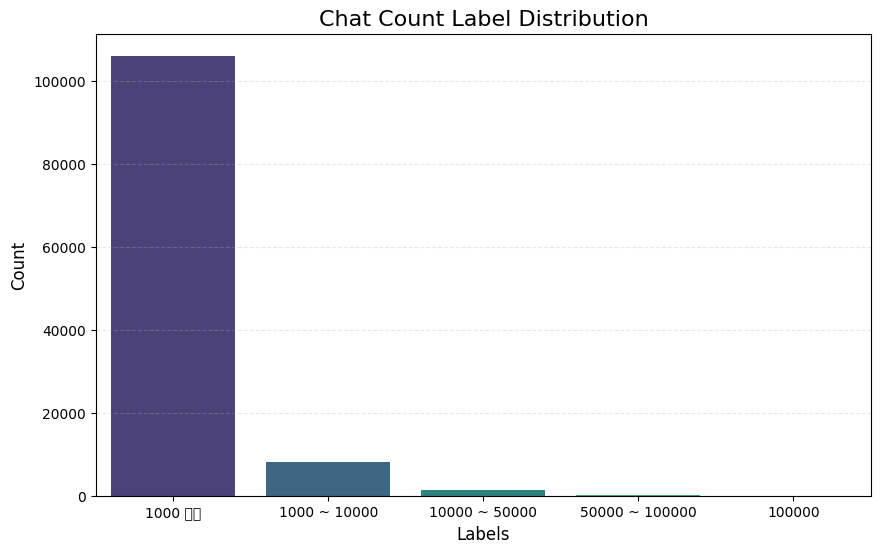

In [20]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# 라벨별 데이터 개수 집계
label_counts = chat_rnk['label'].value_counts().sort_index()

# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Chat Count Label Distribution', fontsize=16)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


<ipython-input-15-9114a996cabd>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(user_row['cnt'], shade=True)  # Use kdeplot for density estimation


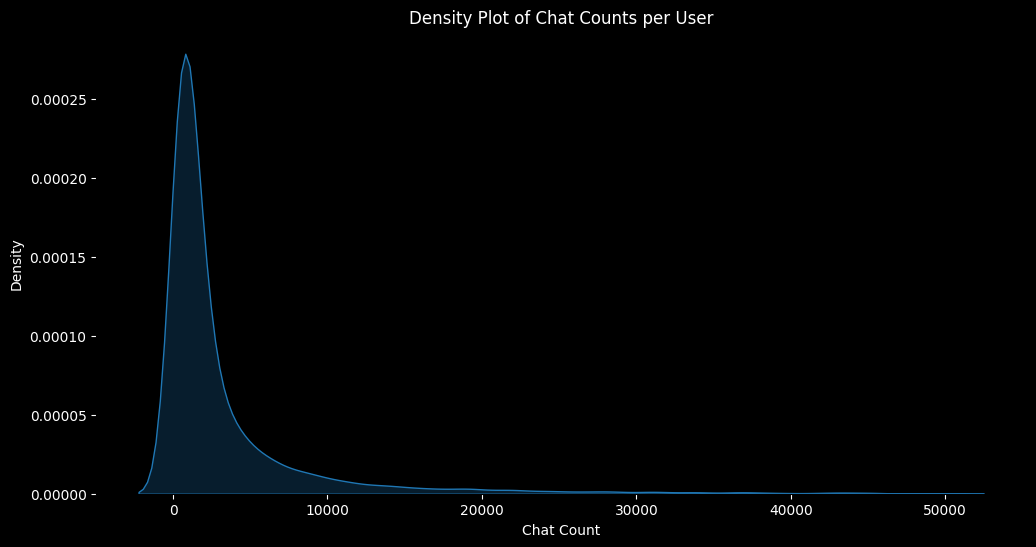

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'chat_rnk' DataFrame is already defined as in your provided code.

user_row = chat_rnk[(chat_rnk['cnt'] > 300) & (chat_rnk['cnt'] < 50000)]

# Create the density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(user_row['cnt'], shade=True)  # Use kdeplot for density estimation

plt.title('Density Plot of Chat Counts per User', color='white')
plt.xlabel('Chat Count', color='white')
plt.ylabel('Density', color='white')

# Customize plot elements for better readability
plt.tick_params(colors='white', which='both')
ax = plt.gca()
ax.set_facecolor('black')
plt.gcf().set_facecolor('black')

plt.show()

### 결국 채팅을 못참은 시청자들..
* 평소에 채팅을 잘 안치는데, 결국 치게 만들었던 방송은 ?

In [39]:
user_by_date = view_df.groupby(['id','date','title']).agg({'cnt': 'sum'}).sort_values(by=['id','date'], ascending=False).reset_index()
user_100 = user_by_date[user_by_date['cnt'] > 100]

In [42]:
# prompt: user_by_date 를 pivot 해주세요. date 가 컬럼에 오도록
# Pivot the user_by_date DataFrame, aggregating duplicate entries with 'sum'
user_by_date_pivot = user_100.pivot_table(
    index=['id'],
    columns='date',
    values='cnt',
    aggfunc='sum'  # or any other appropriate aggregation function like 'mean', 'max', etc.
).reset_index().fillna(0)

# 채팅을 한번이라도 남기면 생방송에 참여한것
user_by_date_pivot['check'] = (user_by_date_pivot.iloc[:, 1:] > 0).sum(axis=1)


date,id,2024-02-04,2024-02-05,2024-02-06,2024-02-07,2024-02-09,2024-02-11,2024-02-12,2024-02-13,2024-02-15,...,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04,2024-12-05
0,0000djss,745.0,167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000xyz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0021130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,007ttme,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0098h,0.0,177.0,0.0,131.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,bapbrid,195.0,0.0,0.0,0.0,0.0,0.0,174.0,212.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,bapunn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,bard999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,bardana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
user_by_date_pivot['check'] = (user_by_date_pivot.iloc[:, 1:] > 0).sum(axis=1)
user_by_date_pivot['live'] = 253
user_by_date_pivot['check_ratio'] = user_by_date_pivot['check'] * 100 / user_by_date_pivot['live']

* 총 253일 방송을 했음

In [ ]:
# user_by_date_pivot['check_ratio'].describe()
user_by_date_pivot[user_by_date_pivot['check_ratio'] > 90].sort_values(by='check_ratio', ascending=False)